In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.discriminant_analysis import StandardScaler

from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set random seed
seed = 42

In [33]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [34]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 8784 non-null   int64  
 1   budget                8784 non-null   int64  
 2   genres                8780 non-null   object 
 3   original_language     8784 non-null   object 
 4   overview              8784 non-null   object 
 5   popularity            8784 non-null   float64
 6   production_companies  8618 non-null   object 
 7   production_countries  8737 non-null   object 
 8   revenue               8784 non-null   int64  
 9   runtime               8784 non-null   float64
 10  spoken_languages      8768 non-null   object 
 11  status                8784 non-null   object 
 12  tagline               8784 non-null   object 
 13  video                 8784 non-null   int64  
 14  vote_average          8784 non-null   float64
 15  vote_count           

# Scoring prediction

In [35]:
X = df.drop(columns=['vote_average', 'category'])
# Drop text columns
# X = X.drop(columns=['belongs_to_collection', 'tagline', 'overview'])
Y = df['category']
print(df)


      adult     budget                                          genres  \
0         0  200000000       Adventure,Action,Thriller,Science Fiction   
1         0  130000000                Science Fiction,Action,Adventure   
2         0  165000000                Action,Adventure,Science Fiction   
3         0  120000000                Action,Adventure,Science Fiction   
4         0   78000000   Fantasy,Action,Crime,Science Fiction,Thriller   
...     ...        ...                                             ...   
8779      0          0  Mystery,Animation,Comedy,Family,Action,Fantasy   
8780      0          0                                     Documentary   
8781      0          0                                    Comedy,Crime   
8782      0          0                                    Action,Crime   
8783      0          0                                    Drama,Comedy   

     original_language                                           overview  \
0                   en  For centur

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


# Feature encoding

In [37]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 8784 non-null   int64  
 1   budget                8784 non-null   int64  
 2   genres                8780 non-null   object 
 3   original_language     8784 non-null   object 
 4   overview              8784 non-null   object 
 5   popularity            8784 non-null   float64
 6   production_companies  8618 non-null   object 
 7   production_countries  8737 non-null   object 
 8   revenue               8784 non-null   int64  
 9   runtime               8784 non-null   float64
 10  spoken_languages      8768 non-null   object 
 11  status                8784 non-null   object 
 12  tagline               8784 non-null   object 
 13  video                 8784 non-null   int64  
 14  vote_count            8784 non-null   float64
 15  cast                 

In [38]:
print(X.head())

   adult     budget                                         genres  \
0      0  200000000      Adventure,Action,Thriller,Science Fiction   
1      0  130000000               Science Fiction,Action,Adventure   
2      0  165000000               Action,Adventure,Science Fiction   
3      0  120000000               Action,Adventure,Science Fiction   
4      0   78000000  Fantasy,Action,Crime,Science Fiction,Thriller   

  original_language                                           overview  \
0                en  For centuries, a small but powerful force of w...   
1                en  One thousand years after cataclysmic events fo...   
2                en  We always knew they were coming back. Using re...   
3                en  Four young outsiders teleport to a dangerous u...   
4                en  He dwells in a world of eternal night, but the...   

   popularity                               production_companies  \
0      31.264  DC Entertainment,De Line Pictures,Warner Bros....  

In [39]:
# Define numerical, categorical, boolean, and text features
from sklearn.pipeline import FunctionTransformer


numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month', 'release_day']
categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  # Adjust max_features as needed
])

# 5. List-based transformer: Convert list of items into count vectors (like multi-hot encoding)
def list_to_str(column):
    return column.apply(lambda x: ','.join(x) if isinstance(x, list) else '')

list_transformer = Pipeline(steps=[
    ('to_string', FunctionTransformer(list_to_str, validate=False)),
    ('countvec', CountVectorizer(tokenizer=lambda x: x.split(','), max_features=100))  # Adjust max_features as needed
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features),
        ('overview', text_transformer, 'overview'),
        ('tagline', text_transformer, 'tagline'),
        ('genres', list_transformer, 'genres'),
        ('production_companies', list_transformer, 'production_companies'),
        ('production_countries', list_transformer, 'production_countries'),
        ('cast', list_transformer, 'cast'),
        ('directors', list_transformer, 'directors')
    ]
)



# Transparent Models

## Decision Tree

### C4.5 Algorithm

Functions needed to help calculate the Information Gain Ratio to be used with the tree. Attention for being a Multi-class Classification problem (4 possible values).


In [40]:
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    #Portion of 'bad' = counts['bad']/np.sum(counts)
    entropy_value = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy_value

In [41]:
# 'category' has 4 possible values, so Entropy can range from 0 (perfectly pure, all values in one class) to 2 (all classes represented equally in the same number each)
e = entropy(df['category'])
elements, counts = np.unique(df['category'], return_counts=True)
print(e)
print(elements)
print(counts)

2.0
['bad' 'good' 'great' 'mediocre']
[2196 2196 2196 2196]


In [42]:
#Information Gain -> the expected reduction in entropy (more proximate to 0 = more pure = reached decision) caused by partitioning the dataset according to split_attribute_name
#                 -> the amount of information gained by spliting the data using split_attribute_name
#                 -> higher values are better
def info_gain(data, split_attribute_name, target_name='category'):
    total_entropy = entropy(data[target_name]) #entropy(df['category'])
    
    # All possible values for the splitting attribute
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    
    weighted_entropy = np.sum([(counts[i]/np.sum(counts)) * entropy(data.where(data[split_attribute_name].astype(str) == values[i]).dropna()[target_name]) for i in range(len(values))])
    
    information_gain = total_entropy - weighted_entropy
    return information_gain

In [43]:
#igainex1 = info_gain(df, 'budget')
#print(igainex1)

#igainex2 = info_gain(df, 'popularity')
#print(igainex2)

#igainex3 = info_gain(df, 'spoken_languages')
#print(igainex3)

In [44]:
#Information Gain Ratio  ->  ratio of information gain to the intrinsic information
#                        -> reduce a bias towards multi-valued attributes by taking the number and size of branches into account when choosing an attribute, biases the decision tree against considering attributes with a large number of distinct values (ex: ID would lead to maximum purity)
#                        -> higher values are better
def info_gain_ratio(data, split_attribute_name, target_name='category'):
    information_gain = info_gain(data, split_attribute_name, target_name)
    
    # Split information = Intrinsic value  -> is a positive number that describes the potential worth of splitting a branch from a node. 
    # This in turn is the intrinsic value that the spliting attribute possesses and will be used to remove the bias in the information gain ratio calculation. (src: Wikipedia)
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    split_information = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(values))])
    
    # Avoidinge division by zero
    if split_information == 0:
        return 0
    
    # Gain ratio is the information gain divided by intrinsic value
    return information_gain / split_information

In [45]:
print(df.columns)

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_average', 'vote_count', 'cast', 'directors', 'release_year',
       'release_month', 'release_day', 'category'],
      dtype='object')


In [46]:
#igrex1 = info_gain_ratio(df, 'budget')
#print(igrex1)

#igrex2 = info_gain_ratio(df, 'popularity')
#print(igrex2)

#igrex3 = info_gain_ratio(df, 'spoken_languages')
#print(igrex3)


In [54]:
def c45_tree(data, original_data, features, target_name='category'):
    # Convert target values to string
    if not data.empty:
        data[target_name] = data[target_name].astype(str)
    
    parent_node_class = data[target_name].mode()[0] if not data.empty else None

    # Base case 1: If all target values are the same, return that class
    if len(np.unique(data[target_name])) <= 1:
        return np.unique(data[target_name])[0]
    
    # Base case 2: If dataset is empty, return the class of the parent node
    elif len(data) == 0:
        return parent_node_class
    
    # Base case 3: If no more features to split on, return the majority class of the current node
    elif len(features) == 0:
        return data[target_name].mode()[0]
    
    # Select the feature with the highest gain ratio
    gain_ratios = [info_gain_ratio(data, feature, target_name) for feature in features]
    best_feature_index = np.argmax(gain_ratios)
    best_feature = features[best_feature_index]
    
    # Create the tree structure (dictionary)
    tree = {best_feature: {}}
    
    # Remove the best feature from the feature list
    features = [i for i in features if i != best_feature]
    
    # For each value of the best feature, split the data and recursively build the tree
    for value in np.unique(data[best_feature].astype(str)):  # Convert to string here
        sub_data = data.loc[data[best_feature] == value]

        # Debugging: size of the sub_data for each value of best_feature
        print(f"Sub Data for {best_feature} = {value}: {len(sub_data)} samples")
    
        subtree = c45_tree(sub_data, original_data, features.copy(), target_name)
        tree[best_feature][value] = subtree
    
    return tree


In [55]:
'''
def tree_predict(tree, sample, parent_node_class=None):
    # If the current tree node is a leaf (a class value), return that class
    if not isinstance(tree, dict):
        return tree  
    
    # The current feature to split on
    feature = next(iter(tree))
    
    # Get the value of this feature in the current sample
    feature_value = sample.get(feature, None)
    
    # Find the subtree that matches this feature value
    subtree = tree[feature].get(feature_value, None)
    
    # If the subtree is None, return the parent node's class (majority class at that node)
    if subtree is None:
        return parent_node_class
    
    # If we found a subtree, recurse into it, passing the parent class down the tree
    return tree_predict(subtree, sample, parent_node_class)
'''


"\ndef tree_predict(tree, sample, parent_node_class=None):\n    # If the current tree node is a leaf (a class value), return that class\n    if not isinstance(tree, dict):\n        return tree  \n    \n    # The current feature to split on\n    feature = next(iter(tree))\n    \n    # Get the value of this feature in the current sample\n    feature_value = sample.get(feature, None)\n    \n    # Find the subtree that matches this feature value\n    subtree = tree[feature].get(feature_value, None)\n    \n    # If the subtree is None, return the parent node's class (majority class at that node)\n    if subtree is None:\n        return parent_node_class\n    \n    # If we found a subtree, recurse into it, passing the parent class down the tree\n    return tree_predict(subtree, sample, parent_node_class)\n"

In [56]:
def tree_predict(tree, sample):
    # Checking if the current tree is a leaf node (i.e., a class label)
    if not isinstance(tree, dict):
        return tree  # Returning the class label

    # Feature to split on
    feature = next(iter(tree)) 
    feature_value = sample[feature]  

    # Checking if the feature value exists in the tree
    if feature_value in tree[feature]:
        # Going down the tree using the corresponding subtree
        return tree_predict(tree[feature][feature_value], sample)
    else:
        # If the value does not exist, return the most common class
        return max(set(tree.values()), key=list(tree.values()).count)  

# Function to predict for an entire test dataset
def tree_predict_all(tree, X_test):
    predictions = []
    for index, sample in X_test.iterrows():
        prediction = tree_predict(tree, sample)
        predictions.append(prediction)
    return predictions


In [57]:
featureList = df.columns[df.columns.isin(['category', 'vote_average']) == False].tolist()


In [58]:
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

print(featureList)
print(Y_train_encoded)


X_train columns: Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')
X_test columns: Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')
['adult', 'budget', 'genres', 'original_language', 'overview', 'popularity', 'production_companies', 'production_countries', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'video', 'vote_count', 'cast', 'directors', 'release_year', 'release_month', 'release_day']
[1 3 0 ... 1 

In [59]:
train_data = pd.concat([X_train, Y_train], axis=1)
print(train_data.columns)

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day', 'category'],
      dtype='object')


In [60]:

#c45tree = c45_tree(df, df, featureList)
#c45tree = c45_tree(X_train, X_train, featureList)
c45tree = c45_tree(train_data, train_data, featureList)


print(c45tree)
#~25-45min

Sub Data for cast = 50 Cent,Joy Bryant,Adewale Akinnuoye-Agbaje,Omar Benson Miller,Terrence Howard,Viola Davis,Ashley Walters,Tory Kittles,Marc John Jefferies,Sullivan Walker,Bill Duke,Mpho Koaho,Serena Reeder,Russell Hornsby,Vanessa Madden,Joseph Pierre,Ryan Allen,Brendan Jeffers,Anastasia Hill,Zainab Musa,Lawrence Bayne,Boyd Banks,Lenno Britos,Mykelti Williamson,Leon: 1 samples
Sub Data for cast = 50 Cent,Ryan Phillippe,Bruce Willis,James Remar,Randy Couture,Will Yun Lee,Shaun Toub,Susie Abromeit,Jay Karnes,Jordan Trovillion,Ambyr Childers,Omar J. Dorsey,Theo Kypri,Richard Goteri,Jenna Dewan,Rory Markham,Brett Granstaff,Ralph Lister,Alex Safi,Rich Komenich: 1 samples
Sub Data for cast = Aamir Khan,Fatima Sana Shaikh,Sanya Malhotra,Sakshi Tanwar,Aparshakti Khurana,Zaira Wasim,Suhani Bhatnagar,Girish Kulkarni,Vivan Bhatena,Ritwik Sahore,Ravi Aneja,Anurag Arora,Mahesh Balraj,Anmol Charan,Karamveer Choudhary,Ishika Gagneja,Badrul Islam,Jagbir,Olamilekan Akanbi Jason,Hafiz Khan,Sumit Khan

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Amy Adams,Christian Bale,Bradley Cooper,Jennifer Lawrence,Jeremy Renner,Louis C. K.,Jack Huston,Michael Peña,Shea Whigham,Alessandro Nivola,Elisabeth Röhm,Paul Herman,Saïd Taghmaoui,Matthew Russell,Thomas Matthews,Adrian Martinez,Anthony Zerbe,Colleen Camp,Steve Gagliastro,Christopher Tarjan,Zachariah Supka,Christy Scott Cashman,Simon Hamlin,Martie Barylick,Dawn Olivieri,Erica McDermott,Dicky Eklund Jr.,Robert De Niro,John Franchi,Danny Corbo,Sonny Corbo,Jack Jones,Gavin Maddox Bergman,Mickey O'Keefe: 1 samples
Sub Data for cast = Amy Adams,Christoph Waltz,Danny Huston,Krysten Ritter,Terence Stamp,Jon Polito,Madeleine Arthur,Delaney Raye,James Saito,Farryn VanHumbeck,Guido Furlani,Elisabetta Fantone,Emily Maddison,Jason Schwartzman,Brent Chapman,Gabe Khouth,Dylan Kingwell,Peter Kelamis,Deni DeLory,Desiree Zurowski,Vincent Gale,Fred Keating,Byron Bertram,Heather Doerksen,Eliza Norbury,Ryan Beil,Frenchy Gagne,Fiona Vroom,Jill Morrison,Leela Savasta,Linda Sato,Traci To

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Ben Stiller,Jennifer Aniston,Philip Seymour Hoffman,Debra Messing,Alec Baldwin,Hank Azaria,Bryan Brown,Michele Lee,Bob Dishy,Missi Pyle,Jsu Garcia,Judah Friedlander,Kevin Hart,Masi Oka,Kym Whitley,Amy Hohn,Nathan Dean,Cheryl Hines,Caroline Aaron,Christina Kirk,Todd Stashwick,Robb Skyler,Edward Conna,Bruce Nozick,Mari Endo,Mark Adair-Rios,Michael Shamberg,Nick Jameson,Gustavo Vargas,Carmit Bachar,Alison Faulk: 1 samples
Sub Data for cast = Ben Stiller,Kristen Wiig,Sean Penn,Adam Scott,Kathryn Hahn,Patton Oswalt,Shirley MacLaine,Ólafur Darri Ólafsson,Adrian Martinez,Gunnar Helgason,Terence Bernie Hines,Alex Anfanger,Gary Wilmes,Jon Daly,Asta Paredes,Gurdeep Singh,Paul Fitzgerald,Grace Rex,Amanda Naughton,Nolan Carley,Joey Slotnick,Marcus Antturi,Amy Stiller,Rosamund Gundmundsdottir,Stuart Cornfeld,Maariu Olsen,Makka Kleist,Þórhallur Sigurðsson,Ari Matthíasson,Hendrikus Schraven,Finni Johannsson,Eysteinn Gardarsson,José Alcántara,Rodrigo Espinosa,Seba Alón,Miguel Baez-

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Carmen Xtravaganza,Brooke Xtravaganza,Andre Christian,Dorian Corey,Paris Dupree,Pepper LaBeija,Junior LaBeija,Willi Ninja,Sandy Ninja,Kim Pendavis,Freddie Pendavis,Sol Williams Pendavis,Avis Pendavis,Octavia St. Laurent,Stevie St. Laurent,Angie Xtravaganza,Bianca Xtravaganza,Danny Xtravaganza,David Xtravaganza,David Ian Xtravaganza,David the Father Xtravaganza,Venus Xtravaganza: 1 samples
Sub Data for cast = Carmiña Martínez,Natalia Reyes,Jhon Narváez,Greider Meza,José Vicente,José Acosta,Juan Bautista Martínez,Miguel Viera,Sergio Coen,Aslenis Márquez,José Naider,Yanker Díaz: 1 samples
Sub Data for cast = Carol Duarte,Julia Stockler,Fernanda Montenegro,Gregório Duvivier,Bárbara Santos,Flávia Gusmão,Maria Manoella,Cristina Pereira,Nikolas Antunes,Cláudio Gabriel,Flávio Bauraqui,Gillray Coutinho,Alexandre Paz,Andressa Cabral,Eduardo Tornaghi,Fernando Ceylão,Hugo Cruz,Lumi Kin,Luana Xavier,Marcello Melo,Maria Carolina Basílio,Márcio Vito,Natália Caruso,Pablo Pêgas,Rafa

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Chris Rock,Rosario Dawson,J.B. Smoove,Gabrielle Union,Romany Malco,Hayley Marie Norman,Anders Holm,Cedric the Entertainer,Kevin Hart,Adam Sandler,Whoopi Goldberg,Jerry Seinfeld,Tracy Morgan,Sherri Shepherd,Leslie Jones,Ben Vereen,Tom Papa,Brian Regan,DMX,Jay Pharoah,Taraji P. Henson,Gabourey Sidibe,Annaleigh Ashford,Greta Lee,Hassan Johnson,Tichina Arnold,Phillip Boykin: 1 samples
Sub Data for cast = Chris Tucker,Jackie Chan,Hiroyuki Sanada,Max von Sydow,Yvan Attal,Roman Polanski,Zhang Jingchu,Philip Baker Hall,Noémie Lenoir,Youki Kudoh,Tzi Ma,Dana Ivey,Henry O,Mia Tyler,Michael Chow,Kentaro,Ann Christine,Darryl Chan,Sarah Shahi: 1 samples
Sub Data for cast = Chrissy Metz,Topher Grace,Mike Colter,Josh Lucas,Rebecca Staab,Lisa Durupt,Alissa Skovbye,Isaac Kragten,Marcel Ruiz,Nikolas Dukic,Travis Bryant,Sam Trammell,Dennis Haysbert,Victor Zinck Jr.,Kristen Harris,Nancy Sorel,Stephanie Czajkowski,Taylor Mosby,Maddy Martin,Connor Peterson,Mel Marginet,Logan Creran,Isla G

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Dany Boon,Valérie Bonneton,Line Renaud,Pierre Richard,Laurence Arné,Guy Lecluyse,François Berléand,Juliane Lepoureau,Yan Tual,Ludovic Pinette,Judi Beecher,Stéphane Pézérat,Aladin Reibel,Thomas VBD,Antonia de Rendinger,Ludmila Mikhailova,Slimane Majdi,Clémence Beauxis,Silvie Laguna,Claudia Tagbo,Nathalie Blanc,Jean-Pascal Abribat,Pierre Buf,Gaetano Laury,Nicolas White,Vincent Primault,Dan Cohen,Jeanfi Janssens,Hugues Boucher,Patrick Brossard,Karina Beuthe,Françoise Thuries,Véronique Gallet,Oleg Eyben,Jean-Noël Martin,Julie Schotsmans,Anaelle Delouya,Sandy Lobry,Kad Merad,Claire Chazal,Pascal Obispo,Julia Vignali,Arthur: 1 samples
Sub Data for cast = Danyil Kamenskyi,Natalia Sumska,Yeva Kosheva,Roman Lutskyi,Slava Krasovska,Oleh Voloshchenko,Ivan Denysenko,Alexander Komarov: 1 samples
Sub Data for cast = Dara McGarry,Tom Selleck,Tom Kenny,Jordan Fry,Stephen J. Anderson,Laurie Metcalf,Angela Bassett,Wesley Singerman,Nicole Sullivan,Harland Williams,Daniel Hansen,Matthe

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Eileen Brennan,Tim Curry,Madeline Kahn,Christopher Lloyd,Michael McKean,Martin Mull,Lesley Ann Warren,Colleen Camp,Lee Ving,Bill Henderson,Jane Wiedlin,Jeffrey Kramer,Kellye Nakahara,Will Nye,Rick Goldman,Don Camp,Howard Hesseman: 1 samples
Sub Data for cast = Eili Harboe,Kaya Wilkins,Henrik Rafaelsen,Ellen Dorrit Petersen,Grethe Eltervåg,Marte Magnusdotter Solem,Anders Mossling,Vanessa Borgli,Steinar Klouman Hallert,Ingrid Unnur Giæver,Oskar Pask,Gorm Grømer,Camilla Belsvik,Martha Kjørven,Ingrid Jørgensen Dragland,Lars Berge,Vibeke Lundquist,Sigve Bøe,Isabel Christine Andreasen,Tom Louis Lindstrøm,Irina Eidsvold Tøien,Ludvig Algeback,Ian Twedmark,Vidar Fransson,Tommy Larsson: 1 samples
Sub Data for cast = Elaine Klimaszewski,Jonathan Bennett,Kal Penn,Donald Faison,Charlie Talbert,Aaron Himelstein,Vincent Pastore,Diane Klimaszewski,Lin Shaye,Graham Beckel,Jaime Pressly,Chuck Liddell,Brent Briscoe,Marisa Petroro: 1 samples
Sub Data for cast = Eli Brown,Natalie Zea,Ma

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = George MacKay,Dean-Charles Chapman,Mark Strong,Andrew Scott,Richard Madden,Claire Duburcq,Colin Firth,Benedict Cumberbatch,Daniel Mays,Adrian Scarborough,Chris Walley,Nabhaan Rizwan,Jamie Parker,Tommy French,Paul Tinto,Billy Postlethwaite,Richard McCabe,Justin Edwards,Jonny Lavelle,Gabriel Akuwudike: 1 samples
Sub Data for cast = George Nader,Claudia Barrett,Gregory Moffett,John Mylong,Selena Royle,Pamela Paulson,George Barrows,John Brown: 1 samples
Sub Data for cast = George O’Brien,Janet Gaynor,Margaret Livingston,Bodil Rosing,J. Farrell MacDonald,Ralph Sipperly,Jane Winton,Arthur Housman,Eddie Boland,Herman Bing,Sidney Bracey,Gino Corrado,Vondell Darr,Sally Eilers,Gibson Gowland,Thomas Jefferson,Bob Kortman,F.W. Murnau,Barry Norton,Robert Parrish,Sally Phipps,Harry Semels,Phillips Smalley,Leo White,Clarence Wilson: 1 samples
Sub Data for cast = George Peck,Emily Harrison,Josh Green,Michael Guerin,Michael Sollenberger,Marc Newburger,Scott Boyer,Jason Dean Booher,R

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Héloïse Martin,Sylvie Testud,Rayane Bensetti,Cyril Gueï,Ina Castagnetti,Oulaya Amamra,Jimmy Labeeu,Lou Gala,Blanche Gardin,Bruno Salomone,François Rollin,Marie-Ève Perron,Sandra Zidani,Clara Choï: 1 samples
Sub Data for cast = Ian Hart,Rosana Pastor,Frédéric Pierrot,Icíar Bollaín,Tom Gilroy,Angela Clarke,Eoin McCarthy,Suzanne Maddock,Mandy Walsh,Miguel Cabrillana,Jordi Dauder,Pep Molina,Francesc Orella,Daniel Muñoz: 1 samples
Sub Data for cast = Ian McCulloch,Louise Marleau,Marino Masé,Siegfried Rauch,Gisela Hahn,Carlo De Mejo,Carlo Monni,Mike Morris,Brigitte Wagner,Angelo Ragusa,Martin Sorrentino: 1 samples
Sub Data for cast = Ian McKellen,Laura Linney,Milo Parker,Hiroyuki Sanada,Roger Allam,Frances de la Tour,Hattie Morahan,Phil Davis,Patrick Kennedy,John Sessions,Frances Barber,Charles Maddox,Takako Akashi,Zak Shukor,Michael Culkin,David Foxxe,Oliver Devoti,Mike Burnside,Nicholas Rowe,Sam Coulson,Hermione Corfield,Kit Connor,Zoe Rainey,Eileen Davies,Colin Starkey

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Jason Statham,Alessandro Gassman,Amber Valletta,Kate Nauta,Matthew Modine,Jason Flemyng,Keith David,Hunter Clary,Shannon Briggs,François Berléand,Raymond Tong,George Kapetan,Jeff Chase,Gregg Weiner,Gregg Davis,Marty Wright,AnnaLynne McCord,Reggie Pierre,Elie Thompson,Adam Faldetta,Michael House,Tim Ware,Liv Davalos Maier,Damaris Justamante,Andy Horne,Doug MacKinnon,Marc Macaulay,Bill Wilson,Robert Small,Jim R. Coleman,Heath Kelts,Chris Campbell,Paul Tei,Ernest Harden Jr.,Tim Powell,Shelah Marie,Tom Derek,Serafin Falcon,Max Osterweis,Laurence Gormezano,Jay Amor,Zafer Atassi,Scott Dale,Vincent De Paul,Patricio Doren,Roberto Escobar,Richard Fitzpatrick,Jesse Holland,Erik Joseph,Elissa Kapneck,Dave Knight,Jeff Moldovan,Bruce Perkins,Frank Tedesco,Erik Townsend,Cleveland Markus Walton,Jimmy Star: 1 samples
Sub Data for cast = Jason Statham,Amy Smart,David Carradine,Dwight Yoakam,Bai Ling,Clifton Collins Jr.,José Pablo Cantillo,Efren Ramirez,Julanne Chidi Hill,Reno Wilson

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Jodi Lyn O'Keefe,Robert Patrick,Robert Knepper,Amaury Nolasco,Rockmond Dunbar,Zhu Zhu,Andy Mackenzie,John Edward Lee,Thom Williams,Robert Crayton,Trent Brya,Dean Cudworth: 1 samples
Sub Data for cast = Jodie Foster,Chow Yun-Fat,Bai Ling,Tom Felton,Syed Alwi,Randall Duk Kim,Kay Siu Lim,Melissa Campbell,Keith Chin,Mano Maniam,Shanthini Venugopal,Deanna Yusoff,Geoffrey Palmer,Ann Firbank,Bill Stewart,Sean Ghazi,K.K. Moggie,Dharma Harun,Harith Iskander,Yank Kassim,Afdlin Shauki,Swee Lin Neo,Ramli Hassan,Robert Hands,Lim Yu-Beng,Kenneth Tsang,Kee Thuan Chye,Patrick Teoh,Aimi Aziz,Ellie Suriaty Omar,Tina Siew Ting Lee,Ruby Wong,Zaridah Abdul Malik,Fariza Azlina,Ahmad Mazlan,Razif Salimin,Zaibo,Pak Ling,Mahmud Ali Basah,Zulhaila Siregar,Espérance Pham Thai Lan,Jean-Luc Russier: 1 samples
Sub Data for cast = Jodie Foster,Matthew McConaughey,James Woods,John Hurt,Tom Skerritt,William Fichtner,David Morse,Angela Bassett,Geoffrey Blake,Max Martini,Rob Lowe,Jake Busey,Jena Malo

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Jude Law,Marisa Tomei,Omar Epps,Jane Krakowski,Renée Taylor,Jeff Harding,Sienna Miller,Nia Long,Susan Sarandon,Kevin Rahm,Max Morris,Gedde Watanabe,Tara Summers,Sam Vincenti,Jo Yang,Claudette Mink,Katherine LaNasa,Anouska De Georgiou,Anastasia Griffith,Jefferson Mays,Deborah Lynn-Shyer,Veronica Clifford,Sondra James,Dick Latessa,Graydon Carter,Steve Morphew,Finlay Robertson,Edward Hogg,Martha Cope,Ben Jackson,Charlotte Moore,Cosima Shaw,Marjan Neshat,Gilbert S. Williams,Saidah Arrika Ekulona,Stephen Gaghan,Paul Brooke: 1 samples
Sub Data for cast = Jude Law,Nicole Kidman,Renée Zellweger,Eileen Atkins,Brendan Gleeson,Philip Seymour Hoffman,Natalie Portman,Emily Deschanel,Giovanni Ribisi,Donald Sutherland,Ray Winstone,Kathy Baker,Charlie Hunnam,Ethan Suplee,Jena Malone,Lucas Black,Taryn Manning,Tom Aldredge,James Rebhorn,Cillian Murphy,Jack White,William Boyer,Jamie Lee,Jen Apgar: 1 samples
Sub Data for cast = Jude Law,Rachel Weisz,Ed Harris,Joseph Fiennes,Bob Hoskins

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Kip Pardue,Brian Hallisay,John Hensley,Sarah Habel,Chris Coy,Skyler Stone,Thomas Kretschmann,Zulay Henao,Nickola Shreli,Derrick Carr,Frank Alvarez,Evelina Turen,Kelly Thiebaud,Tim Holmes,Barry Livingston,Danny Jacobs,Mike Eshaq,Rich Ronat,Don Richard,Joe Virzi,Michael Knight,Sam Brice,Alicia Vela-Bailey,Jeanette Manderachia,Cassie Keller,Gordon Michaels,Nesti Gee,Wendy Aaron,Rachel Adams,Zoe Aggeliki,Michael Bugard,Ron Causey,Tiffani Elise Edwards,James Feaheny,Michael Felsher,Ron Heisler,Aaron Helferich,Yukita Kusunoki,Aine Leicht,Bill Lumbert,Jon Manthei,Jeremy Matson,Ari Rufino,Steven Schoolmeesters,Angelique Sky,Joseph Smith,Amanda Wright: 1 samples
Sub Data for cast = Kirin Kiki,Masatoshi Nagase,Kyara Uchida,Miki Mizuno,Etsuko Ichihara,Miyoko Asada,Taiga Nakano,Wakato Kanematsu,Miu Takeuchi,Saki Takahashi,Yurie Murata: 1 samples
Sub Data for cast = Kirk Barker,Stefan Buttler,Adrian Bouchet,David Sterne,Nigel Cooke,Charlotte Brimble,Nicholas Asbury,Andrew Grose,

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Lucy Hale,Violett Beane,Tyler Posey,Hayden Szeto,Landon Liboiron,Sophia Taylor Ali,Nolan Gerard Funk,Sam Lerner,Gary Anthony Williams,Brady Smith,Aurora Perrineau,Tom Choi,Morgan Lindholm: 1 samples
Sub Data for cast = Lucy Liu,Michael Chiklis,Carla Gugino,James D'Arcy,Marilyn Manson,Robert Forster,Samaire Armstrong,Cameron Richardson,Allan Rich,Holt McCallany,Mako,Elden Henson,Margo Harshman,Kevin Wheatley,Cameron Goodman,Samantha Shelton,Anastasia Baranova,India King,Paul Cassell,Natsuko Ohama,Christina Ahn: 1 samples
Sub Data for cast = Lucy Loken,Rusty Joiner,Laura Bilgeri,Alexandria DeBerry,Dakota Bruton,Theresa Sutera,Vin Morreale Jr: 1 samples
Sub Data for cast = Ludovico Girardello,Valeria Golino,Fabrizio Bentivoglio,Noa Zatta,Christo Jivkov,Kseniya Rappoport,Assil Kandil,Falippo Valese,Enea Barozzi,Riccardo Gasparini,Vernon Dobtcheff,Vilius Tumalavicius,Vincenzo Zampa,Maria Sole Mansutti,Zita Fusco,Francesco Gusmitta,Alexandru Arabagi,Gabriele Benedetti,Win

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Masako Nozawa,Ryou Horikawa,Ryusei Nakao,Kouichi Yamadera,Masakazu Morita,Hiromi Tsuru,Mayumi Tanaka,Masaharu Satō,Toshio Furukawa,Takeshi Kusao,Hikaru Midorikawa,Natsuki Hanae: 1 samples
Sub Data for cast = Masami Nagasawa,Junichi Okada,Keiko Takeshita,Yuriko Ishida,Rumi Hiiragi,Jun Fubuki,Takashi Naitō,Shunsuke Kazama,Nao Ōmori,Teruyuki Kagawa,Haruka Shiraishi,Tsubasa Kobayashi,Aoi Teshima,Goro Miyazaki: 1 samples
Sub Data for cast = Massimo Boldi,Anna Maria Barbera,Biagio Izzo,Paola Minaccioni,Enzo Salvi,Massimo Ceccherini,Loredana De Nardis,Rocco Siffredi,Diana Del Bufalo,Emanuele Bosi,Raffaella Fico,Isabelle Adriani,Guglielmo Scilla,Alessandra Pozzi,Gisella Sofio,Lucia Bodenizza,Mariela Garriga,Margherita Cornali: 1 samples
Sub Data for cast = Massimo Boldi,Anna Maria Barbera,Enzo Salvi,Bruno Arena,Max Cavallari,Biagio Izzo,Lucrezia Piaggio,Loredana De Nardis,Victoria Silvstedt,Donald French,Lodovica Mairè Rogati,Oona O'Connell,Valentino Campitelli,Niccolò Senn

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Monica Vitti,Richard Harris,Carlo Chionetti,Xenia Valderi,Rita Renoir,Lili Rheims,Aldo Grotti: 1 samples
Sub Data for cast = Monika M.,Mark Reeder,Beatrice Manowski,Carola Ewers,Astrid Ewerts,Eva-Maria Kurz,Jörg Buttgereit,Florian Koerner von Gustorf,Florian Koerner von Gustorf: 1 samples
Sub Data for cast = Monsieur Poulpe,Karen Strassman,Davy Mourier,Guangtao Jiang,Zhengyang Ma,Liyang Chen,Xiao Han,Tang Shuiyu,Lin Qiang,Hu Liangwei: 1 samples
Sub Data for cast = Montgomery Clift,Elizabeth Taylor,Shelley Winters,Anne Revere,Keefe Brasselle,Fred Clark,Raymond Burr,Herbert Heyes,Shepperd Strudwick,Frieda Inescort,Kathryn Givney,Walter Sande,Ted de Corsia,John Ridgely,Lois Chartrand,Paul Frees,Robert J. Anderson,Gertrude Astor,Frances Curry,Franklyn Farnum,Bess Flowers,Kathleen Freeman,Art Gilmore,Kenner G. Kemp,Mary Kent,Mike Mahoney,Hank Mann,Harold Miller,William H. O'Brien,Frank O'Connor,Kasey Rogers,Douglas Spencer,Larry Steers,Arthur Tovey,Dorothy Vernon,Josephi

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Park Bo-young,Song Joong-ki,Lee Young-lan,Jang Young-nam,Yoo Yeon-seok,Kim Hyang-gi,Yoo Sung-mok,Seo Dong-Soo,Woo Jung-kook,Nam Jung-hee,Goo Bon-im,Ahn Do-Kyu,Bi Shin,Lee Jun-hyeok,Oh Yeong-seok,Kim Hae-eun,Lee Min-woong,Sung Du-hyung,Cha Jong-ho,Jung In-gum,Kim Eun-sook,Kim Seung-hun,Lee In-ho,Lee Sung-ju,Jang seo-yi,Hung Hi-kwon,Hong Sung-ki,Soel Oh-shin,Han Min-hik,Chuay Kwong-lak,Jo Jae-yun,Ku Lu-han,Kim Chul-jun,Park Young-shik,Kim Jong-goo,Shin Yeong-cheol: 1 samples
Sub Data for cast = Park Seo-jun,Ahn Sung-ki,Woo Do-hwan,Choi Woo-shik,Park Ji-hyun,Jung Ji-hoon,Lee Seung-hee,Shim Hee-sub,Kim Si-eun,Kim Seon-min,Jeong Eui-soon,Kim Beom-soo,Park Jae-hong,Cha Si-won,Lee Seung-joon,Ryu Kyung-soo,Seo Jeong-yeon,Jo Eun-hyung,Lee Jung-hyun,Park Ji-yeol,Shin Min-ho,Kim Jong-wan,Lee Seol,Park Jin-joo,Han Hye-ji: 1 samples
Sub Data for cast = Pat Morita,Hilary Swank,Michael Ironside,Constance Towers,Chris Conrad,Arsenio 'Sonny' Trinidad,Michael Cavalieri,Walton Goggins

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Rob Corddry,Craig Robinson,Clark Duke,Bianca Haase,Chevy Chase,Gillian Jacobs,Collette Wolfe,Adam Scott,Kumail Nanjiani,Kellee Stewart,Josh Heald,Gretchen Koerner,Lisa Loeb,Jessica Williams,Bruce Buffer,Mariana Paola Vicente,Christian Slater,Jason Jones,Olivia Jordan,Christine Bently,Stacey Asaro,Adam Herschman,Kisha Sierra,John Cusack: 1 samples
Sub Data for cast = Rob Corddry,Leslie Bibb,Keegan-Michael Key,Paul Scheer,Rob Huebel,Thomas Lennon,Michael Ian Black,Brittney Alger,Dave Holmes,Alex Berg,Riki Lindhome,David Pasquesi,David Wain,Kumail Nanjiani,Ben Garant,Cathy Shim,Jenny Robertson: 1 samples
Sub Data for cast = Rob Schneider,Colleen Haskell,John C. McGinley,Ed Asner,Guy Torry,Adam Sandler,Michael Caton,Louis Lombardi,Bob Rubin,Pilar Schneider,Scott Wilson,Raymond Ma,Harry Dean Stanton,Norm Macdonald,Noel Gugliemi,Morisa Taylor Kaplan: 1 samples
Sub Data for cast = Rob Schneider,David Carradine,Jennifer Morrison,Scott Wilson,Richard Kind,Sally Kirkland,M. E

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Samantha Robinson,Gian Keys,Laura Waddell,Jeffrey Vincent Parise,Jared Sanford,Robert Seeley,Jennifer Ingrum,Randy Evans,Clive Ashborn,Lily Holleman,Jennifer Couch,Stephen Wozniak,April Showers,Giselle DaMier,Elle Evans,Fair Micaela Griffin,Dani Lennon,Gina Venditti,Frank Farmer,Kyle Derek,Alisha Honoré,Christopher LeCrenn,Neil Gillen,Amy Segal,Jacob Peacock,Ron Kari,Robert Michael Anderson,Jacklyn Chung-Young,Larva,Barry Morse,Max Carson,Lily Abrams,Jonathan Knight,Casey Larios,Amanda Stoer,Michael Davis,Jonathan Beck,Rachel Huggins,Bernard Bullen,Kaye L. Morris,Christian Smith,Bridget Albaugh,Vlad Varro,Lisa Davis,Jillian Smalley,Michael Gabel,Rosie Woodward,Jamie Nelson,Giovanni V. Giusti,Jeremiah Benjamin,Annie Newton,Matthew Jablonsky,R. Brian Falkner,Marilyn Winkle,Jolly Goodfellow,Donna Madach,Elise Massa,Stephen Dudro,Jonathan Peacy,Margaret Baker,Mary Russell,Rage Stewart,Taryn Nicole Piana,Natalie Turner,Lucas DiMedio,Emma Rose,Josh Connor,Tony Ketchum,Dav

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Shelby Young,Chloe Bridges,Carter Jenkins,Mitch Hewer,Taylor Ashley Murphy,Kyle Fain: 1 samples
Sub Data for cast = Shelley Hennig,Heather Sossaman,Renee Olstead,Matthew Bohrer,Moses Storm,William Peltz,Jacob Wysocki,Courtney Halverson,Mickey River,Cal Barnes,Christa Hartsock,Konstantin Khabenskiy: 1 samples
Sub Data for cast = Sheri Moon Zombie,Bruce Davison,Jeff Daniel Phillips,Judy Geeson,Meg Foster,Patricia Quinn,Ken Foree,Dee Wallace,María Conchita Alonso,Richard Fancy,Andrew Prine,Michael Berryman,Sid Haig,Suzanne Voss,Torsten Voges,Lisa Marie,Barbara Crampton,Michael Shamus Wiles,Ernest Lee Thomas,Maria Olsen,Camille Keaton,Clint Howard,Udo Kier,Richard Lynch,Bonita Friedericy,Nancy Linehan Charles,Flo Lawrence,Brynn Horrocks,Susan Gray,Niko Posey,Julian Acosta,Brandon Cruz,Gabriel Pimentel,John 5,Dustin Quick,James Messersmith,Christine Ames,Diana Hart,Silvia Moore,Daniel Roebuck,Judy Thompson,Carlos del Valle,Jobeth Wagner: 1 samples
Sub Data for cast = She

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Taraji P. Henson,Jahi Di'Allo Winston,Danny Glover,Billy Brown,Neal McDonough,Margaret Avery,Xander Berkeley,Rade Šerbedžija,Owen Burke,Alex Ziwak,Jose Guns Alves,Arthur Hiou,Leah Procito,David Chen,Jim Ford,Therese Plaehn,Joseph Oliveira,Marinko Radakovic,Adrian M. Mompoint,Rob Lévesque,Bo Cleary,Ken Kansky,Stew Replogle,Bo Cleary,John Sarnie,Alex Portenko,Al'Jaleel McGhee,Ralph Ayala,Roger Dillingham Jr.,Joseph Collymore,Arthur Hiou: 1 samples
Sub Data for cast = Taraji P. Henson,Josh Brener,Aldis Hodge,Tracy Morgan,Kellan Lutz,Jason Jones,Max Greenfield,Richard Roundtree,Chris Witaske,Paul Brian Johnson,Kausar Mohammed,Taj-Naranja Jenkines,Auston Jon Moore,Lisa Leslie,Phoebe Robinson,Wendi McLendon-Covey,Kristen Ledlow,Devonta Freeman,John Collins,Brian Bosworth,Justin Alvarez,Shane Paul McGhie,Tamala Jones,Erykah Badu,Desi-Ray Morris,Kyra Claxton,Marc Inniss,Christopher Alvarez,Charles Green,Denitra Isler,Jim France,Deja Dee,Shaquille O'Neal,Mark Cuban,Grant Hil

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Tommy Lee Jones,Cedric the Entertainer,Christina Milian,Paula Garcés,Monica Keena,Vanessa Ferlito,Kelli Garner,Anne Archer,Brian Van Holt,Shea Whigham,Terry Dale Parks,R. Lee Ermey,Paget Brewster,Shannon Woodward,Liz Vassey,Curtis Armstrong,Nar Williams,Mark Hanson,Tom Reynolds,Jimmy Ortega,Rick Perry,Stephen Bruton,Bo Kane,Lucien Douglas,Ash Christian,Lucas Calhoun,Chase Ryan Jeffery,Christopher Dahlberg,Jesse De Luna,Megan Evanich: 1 samples
Sub Data for cast = Tommy Lee Jones,Charlize Theron,Susan Sarandon,Frances Fisher,James Franco,Jonathan Tucker,Jason Patric,Josh Brolin,Wes Chatham,Jake McLaughlin,Mehcad Brooks,Wayne Duvall,Brent Briscoe,Barry Corbin,Greg Serano,Zoe Kazan,Brent Sexton,Devin Brochu,Glenn Taranto,Roman Arabia,Jennifer Siebel Newsom,Rick Gonzalez,Loren Haynes,Babak Tafti,Sean Huze,Kathy Lamkin,David Doty,Pab Schwendimann,Josh Meyer,Arron Shiver,Jo Harvey Allen,Chris Browning,David House,Matthew Page,Pierre Barrera,Mike Hatfield,Arlin Alcala,Jame

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Sub Data for cast = Yeong-il Oh,Nam Jeong-im,Lee Soon-jae,Kwang Ho Lee,Cho Kyoung-min,Moon Kang: 1 samples
Sub Data for cast = Yoko Honna,Issey Takahashi,Takashi Tachibana,Shigeru Muroi,Shigeru Tsuyuguchi,Keiju Kobayashi,Yorie Yamashita,Maiko Kayama,Yoshimi Nakajima,Minami Takayama,Mayumi Iizuka,Mai Chiba,Satoru Takahashi,Akiko Sakaguchi,Hiromi Yasuda,Tatsuya Okada,Yoshihiro Imai,Naohisa Inoue,Suguru Egawa,Shiro Kishibe,Mitsuaki Ogawa,Toshio Suzuki: 1 samples
Sub Data for cast = Yoo Ah-in,Park Shin-Hye,Lee Hyun-wook,Jeon Bae-soo,Oh Hye-won,Jeon Woon-jong: 1 samples
Sub Data for cast = Yoo Ah-in,Steven Yeun,Jeon Jong-seo,Kim Soo-kyung,Choi Seung-ho,Moon Sung-keun,Min Bok-gi,Lee Soo-jeong,Ban Hye-ra,Cha Mi-Kyung,Lee Bong-ryeon,Jang Won-hyung,Jeon Seok-chan,Lee Joong-ok,Ok Ja-yeon: 1 samples
Sub Data for cast = Yoo Ji-tae,Lee Jae-eun,Seo Rin,Jung Eun-pyo,Jung Doo-hong,Eul-dong Kim,Ju-hye Ko,Yoon Chan,Eun Won-jae: 1 samples
Sub Data for cast = Yoshikatsu Fujiki,Sumi Mutou,Hiroyuki Kinosha,

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_name] = data[target_name].astype(str)
C:\Users\Azevedo\AppData\Local\Temp\ipykernel_2768\623354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

IndexError: index 0 is out of bounds for axis 0 with size 0

In [29]:
print(X_test.columns)  

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')


In [30]:

#Y_pred = [tree_predict(c45tree, sample, parent_node_class=parent_class) for _, sample in X_test.iterrows()]
#Y_pred_encoded = label_encoder.transform(Y_pred)

Y_pred = tree_predict_all(c45tree, X_test)
Y_pred_encoded = label_encoder.transform(Y_pred)


TypeError: unhashable type: 'dict'

Accuracy:  0.4
['bad', 'good', 'great', 'mediocre']
category
good        1393
mediocre    1095
great        614
bad          383
Name: count, dtype: int64


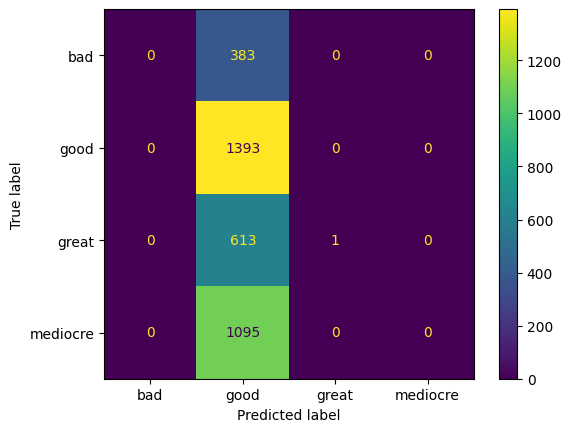

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(Y_test_encoded, Y_pred_encoded)
print("Accuracy: ", accuracy)

# Display unique values and counts
print(sorted(Y_test.unique()))
print(Y_test.value_counts())

# Print confusion matrix for the model
cm = confusion_matrix(Y_test_encoded, Y_pred_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(label_encoder.classes_))
disp.plot()


### CART Algorithm